# Imports

In [385]:
#!pip install statsmodels
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime

# Data

In [ ]:
df_kickstarter = pd.read_csv('../kickstarter_cleaned_BERTPPL_Readability.csv')

# OLS Models

In [ ]:
df_kickstarter = df_kickstarter[~np.isinf(df_kickstarter['bert_score'])]

In [ ]:
df_kickstarter = df_kickstarter[df_kickstarter['bert_score'] < 100]
df_kickstarter = df_kickstarter[df_kickstarter['flesch_kincaid'] < 18]
df_kickstarter = df_kickstarter[df_kickstarter['flesch_kincaid'] > 0]
df_kickstarter = df_kickstarter[df_kickstarter['flesch_reading_ease'] < 100]
df_kickstarter = df_kickstarter[df_kickstarter['flesch_reading_ease'] > 0]

In [ ]:
# Setting up Model Variables by transforming Data Columns

## Date transformations
df_kickstarter['project_launched_at'] = pd.to_datetime(df_kickstarter['project_launched_at'])
df_kickstarter['project_deadline'] = pd.to_datetime(df_kickstarter['project_deadline'])
df_kickstarter['month'] = pd.to_datetime(df_kickstarter['project_launched_at']).dt.month
df_kickstarter['timestamp_launched'] = df_kickstarter['project_launched_at'].apply(lambda x: (datetime.timestamp(x) / 86400))
df_kickstarter['timestamp_deadline'] = df_kickstarter['project_deadline'].apply(lambda x: (datetime.timestamp(x) / 86400))
df_kickstarter['Year'] = pd.to_datetime(df_kickstarter['project_launched_at']).dt.strftime('%Y')
df_kickstarter['Year'] = df_kickstarter['Year'].astype(int) - 2008

## Response Variable
CF_success = df_kickstarter['project_pledged'].apply(lambda x: np.log(x) if x != 0 else 0)
CF_success = CF_success.apply(lambda x: 0 if pd.isna(x) else x)
Backers = df_kickstarter['project_backers'].apply(lambda x: np.log(x) if x != 0 else 0)
Backers = Backers.apply(lambda x: 0 if pd.isna(x) else x)
success_binary = df_kickstarter['project_state'].apply(lambda x: 1 if x == "successful" else 0)

## Explanatory Variables
year = df_kickstarter['Year']
bertscore = df_kickstarter['bert_score']
bertscoreXyear = bertscore * year
log_bertscore = df_kickstarter['bert_score'].apply(lambda x: np.log(x))
log_bertscoreXyear = log_bertscore * year
flesch_grade = df_kickstarter['flesch_kincaid']
flesch_grade_squared = df_kickstarter['flesch_kincaid'] * df_kickstarter['flesch_kincaid']
flesch_gradeXyear = flesch_grade * year
flesch_reading_ease = df_kickstarter['flesch_reading_ease']
flesch_reading_ease_squared = df_kickstarter['flesch_reading_ease'] * df_kickstarter['flesch_reading_ease']
flesch_reading_easeXyear = flesch_reading_ease * year

##Control Variables
loved_project = df_kickstarter['project_staff_pick']
video = df_kickstarter['project_video_url'].apply(lambda x: 0 if pd.isna(x) else 1)
funding_duration = df_kickstarter['timestamp_deadline'] - df_kickstarter['timestamp_launched']
number_of_words = df_kickstarter['num_words'].apply(lambda x: np.log(x))
log_funding_goal = df_kickstarter['project_goal'].apply(lambda x: np.log(x))
updates = df_kickstarter['updates_until_deadline']
rewards = df_kickstarter['project_rewards']
number_projects = df_kickstarter['project_creator_project_number'].apply(lambda x: 0 if pd.isna(x) else x)

##Dummies
df_kickstarter['selected_category'] = df_kickstarter['project_parent_category_id'].fillna(df_kickstarter['project_category_id'])
category_dummies = pd.get_dummies(df_kickstarter['selected_category'], prefix='category', drop_first=True)
month_dummies = pd.get_dummies(df_kickstarter['month'], prefix='month', drop_first=True)
year_dummies = pd.get_dummies(df_kickstarter['Year'], prefix='year', drop_first=True)

## Code for Regression Analytics

In [ ]:
# base code
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


## Descriptive Statistics

In [ ]:
# Create a new DataFrame to store the variables
df_statistics = pd.DataFrame({
    'Bert Score': bertscore,
    'Flesch Reading Ease': flesch_reading_ease,
    'Flesch Kincaid Grade Level': flesch_grade,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})

# Calculate mean, standard deviation, and correlations
mean_values = df_statistics.mean().round(2)
std_dev_values = df_statistics.std().round(2)
correlations = df_statistics.corr().round(4)

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Variable': mean_values.index,
    'Mean': mean_values.values,
    'Std.': std_dev_values.values,
})

# Add correlations to the summary DataFrame
correlation_columns = [f'{i}' for i in range(1, len(df_statistics.columns) + 1)]
for i, col in enumerate(df_statistics.columns):
    summary_df[correlation_columns[i]] = correlations[col].values

# Convert the summary DataFrame to LaTeX format
merged_table_latex = summary_df.to_latex(index=False)

# Print the merged LaTeX table for summary statistics and correlations
print(merged_table_latex)

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
                  Variable &  Mean &  Std. &       1 &       2 &       3 &       4 &       5 &       6 &       7 &       8 &       9 &      10 &      11 \\
\midrule
                Bert Score & 13.73 &  8.91 &  1.0000 &  0.0740 & -0.1572 &  0.0279 & -0.0068 & -0.0391 &  0.0515 & -0.0115 &  0.0963 &  0.0576 &  0.0885 \\
       Flesch Reading Ease & 58.62 & 11.44 &  0.0740 &  1.0000 & -0.9214 & -0.0895 & -0.1029 & -0.0241 & -0.1224 & -0.1557 & -0.0144 & -0.0445 &  0.0289 \\
Flesch Kincaid Grade Level & 10.11 &  2.65 & -0.1572 & -0.9214 &  1.0000 &  0.0625 &  0.0772 &  0.0172 &  0.0958 &  0.1243 & -0.0049 &  0.0374 & -0.0356 \\
             Loved Project &  0.10 &  0.30 &  0.0279 & -0.0895 &  0.0625 &  1.0000 &  0.1468 & -0.0436 &  0.2077 &  0.0882 &  0.2374 &  0.1939 &  0.0563 \\
                     Video &  0.71 &  0.45 & -0.0068 & -0.1029 &  0.0772 &  0.1468 &  1.0000 & -0.0026 &  0.2510 &  0.2019 &  0.1663 &  0.2417 & -0.0362 \\
          Fund

C:\Users\CoolerMaster\AppData\Local\Temp\ipykernel_258516\795964855.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  merged_table_latex = summary_df.to_latex(index=False)


## Bert Score with time

In [ ]:
print(bertscore.mean())
print(bertscore.std())

2.4773080478501432
0.5377961959277083


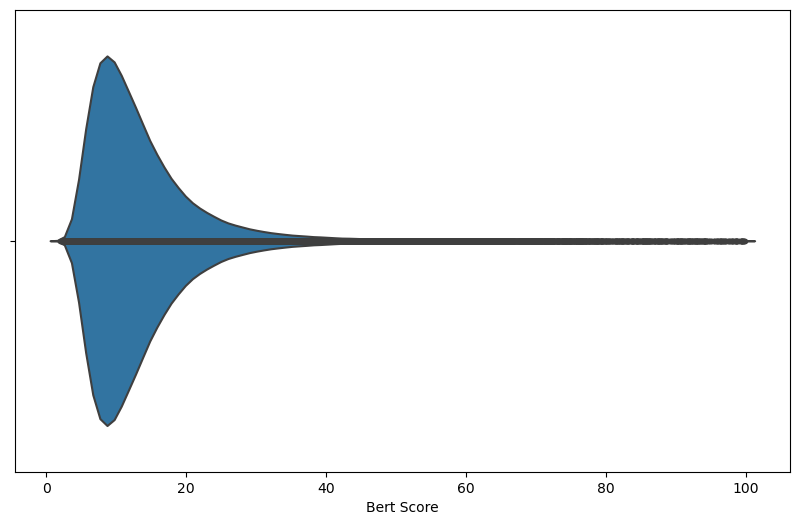

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(x='Bert Score', data=df_bert, inner='points')
plt.show()

In [ ]:
# Create a new DataFrame to store the variables
df_bert = pd.DataFrame({
    'Year': year,
    'Log(Bert Score)': log_bertscore,#.apply(lambda x: np.log(x)),
    #'Bert Score^2': bertscore * bertscore, #.apply(lambda x: np.log(x)) * bertscore.apply(lambda x: np.log(x)),
    'Log(Bert Score) * Year': log_bertscoreXyear,
    #'Log(Bert Score^2) * Year':  log_bertscore * log_bertscore * year,
    #'Readability': readability,
    #'Readability * Time': readabilityXyear,
    #'Readability^2': readability_squared,
    #'Readability^2 * Year': readability_squaredXyear,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
# Concatenate the dummy variables
df_bert = pd.concat([df_bert, month_dummies], axis=1)
df_bert = pd.concat([df_bert, category_dummies], axis=1)

X_bert = df_bert
# Add a constant (intercept) to the feature matrix
X_bert_with_intercept = sm.add_constant(X_bert)

# Fit for model without time
model14 = sm.OLS(Backers, X_bert_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
#print(model_bert.summary())

In [ ]:
# 6. Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Features"] = X_bert_with_intercept.columns
vif["VIF"] = [variance_inflation_factor(X_bert_with_intercept.values, i) for i in range(X_bert_with_intercept.shape[1])]
print(vif)

                Features          VIF
0                  const  1399.246092
1                   Year   211.958547
2             Bert Score   217.987147
3           Bert Score^2   224.006883
4      Bert Score * Year  1092.753603
5    Bert Score^2 * Year   456.235076
6          Loved Project     1.118143
7                  Video     1.211541
8       Funding Duration     1.087356
9   Log(Number of Words)     1.423589
10     Log(Funding Goal)     1.281811
11               Updates     1.288957
12               Rewards     1.350234
13    Number of projects     1.106867
14               month_2     1.881422
15               month_3     1.942336
16               month_4     1.895857
17               month_5     1.915444
18               month_6     1.905691
19               month_7     1.948680
20               month_8     1.907433
21               month_9     1.875164
22              month_10     1.940304
23              month_11     1.856974
24              month_12     1.616805
25          

In [ ]:
df_R = pd.DataFrame({
    'CF_success': CF_success,
    'bertscore': bertscore,
    'loved_project': loved_project,
    'video': video,
    'funding_duration': funding_duration,
    'number_of_words': number_of_words,
    'log_funding_goal': log_funding_goal,
    'updates': updates,
    'rewards': rewards,
    'number_projects': number_projects,
    'year' : year
})

## Flesch-Kincaid Grade Level

In [ ]:
print(flesch_grade.mean())
print(flesch_grade.std())

10.478234906537523
3.5378734361318926


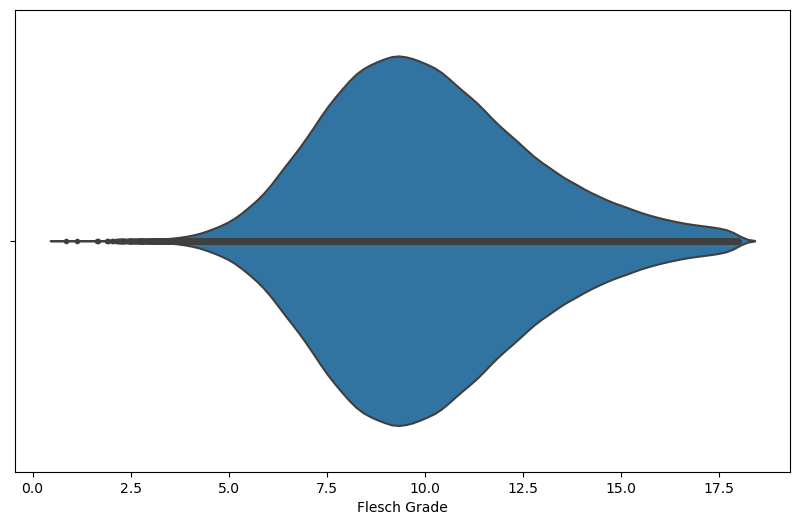

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(x='Flesch Grade', data=df_flesch_grade, inner='points')
plt.show()

In [ ]:
# Create a new DataFrame to store the variables
df_flesch_grade = pd.DataFrame({
    'Year': year,
    #'Log(Bert Score)': bertscore,
    #'Log(Bert Score) * Year': bertscoreXyear,
    'Flesch Grade': flesch_grade,
    'Flesch Grade * Year': flesch_gradeXyear,
    'Flesch Grade^2': flesch_grade_squared,
    #'Readability^2 * Year': readability_squaredXyear,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
# Concatenate the dummy variables
df_flesch_grade = pd.concat([df_flesch_grade, month_dummies], axis=1)
df_flesch_grade = pd.concat([df_flesch_grade, category_dummies], axis=1)

X_flesch_grade = df_flesch_grade
# Add a constant (intercept) to the feature matrix
X_flesch_grade_with_intercept = sm.add_constant(X_flesch_grade)

# Fit for model without time
model9 = sm.OLS(CF_success, X_flesch_grade_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
#print(model_flesch_grade.summary())

In [ ]:
# 6. Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Features"] = X_flesch_grade_with_intercept.columns
vif["VIF"] = [variance_inflation_factor(X_flesch_grade_with_intercept.values, i) for i in range(X_flesch_grade_with_intercept.shape[1])]
print(vif)

                Features         VIF
0                  const  240.984002
1                   Year    1.205145
2           Flesch Grade   38.902001
3         Flesch Grade^2   38.623184
4          Loved Project    1.119087
5                  Video    1.213562
6       Funding Duration    1.087984
7   Log(Number of Words)    1.409112
8      Log(Funding Goal)    1.290697
9                Updates    1.286364
10               Rewards    1.348394
11    Number of projects    1.100536
12               month_2    1.882087
13               month_3    1.940551
14               month_4    1.895612
15               month_5    1.913994
16               month_6    1.905637
17               month_7    1.947468
18               month_8    1.907623
19               month_9    1.874811
20              month_10    1.940593
21              month_11    1.858300
22              month_12    1.615014
23          category_3.0    1.555305
24          category_6.0    1.115395
25          category_7.0    1.905196
2

## Flesch-Kincaid Reading Ease

In [ ]:
print(flesch_reading_ease.mean())
print(flesch_reading_ease.std())

57.4815639408789
13.416134221704578


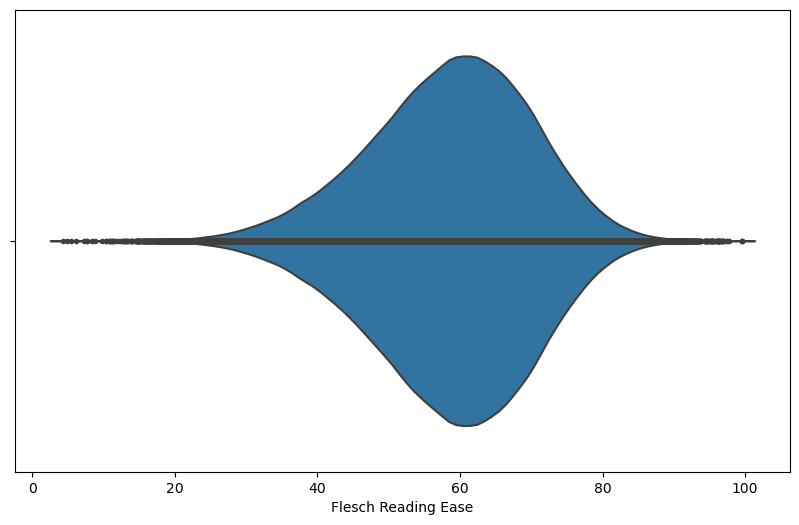

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for the 'difference_average_topic_prevalence' variable
plt.figure(figsize=(10, 6))
sns.violinplot(x='Flesch Reading Ease', data=df_flesch_reading_ease, inner='points')
plt.show()

In [ ]:
# Create a new DataFrame to store the variables
df_flesch_reading_ease = pd.DataFrame({
    'Year': year,
    #'Log(Bert Score)': bertscore,
    #'Log(Bert Score) * Year': bertscoreXyear,
    'Flesch Reading Ease': flesch_reading_ease,
    'Flesch Reading Ease * Year': flesch_reading_easeXyear,
    'Flesch Reading Ease^2': flesch_reading_ease_squared,
    #'Readability^2 * Year': flesch_reading_ease_squared * year,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
# Concatenate the dummy variables
df_flesch_reading_ease = pd.concat([df_flesch_reading_ease, month_dummies], axis=1)
df_flesch_reading_ease = pd.concat([df_flesch_reading_ease, category_dummies], axis=1)

X_flesch_reading_ease = df_flesch_reading_ease
# Add a constant (intercept) to the feature matrix
X_flesch_reading_ease_with_intercept = sm.add_constant(X_flesch_reading_ease)

# Fit for model without time
model12 = sm.OLS(CF_success, X_flesch_reading_ease_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
#print(model_flesch_reading_ease.summary())

In [ ]:
# 6. Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Features"] = X_flesch_reading_ease_with_intercept.columns
vif["VIF"] = [variance_inflation_factor(X_flesch_reading_ease_with_intercept.values, i) for i in range(X_flesch_reading_ease_with_intercept.shape[1])]
print(vif)

                Features         VIF
0                  const  168.918692
1                   Year    1.197336
2    Flesch Reading Ease    1.092532
3          Loved Project    1.120997
4                  Video    1.214649
5       Funding Duration    1.087750
6   Log(Number of Words)    1.392121
7      Log(Funding Goal)    1.293683
8                Updates    1.285890
9                Rewards    1.348427
10    Number of projects    1.100439
11               month_2    1.882078
12               month_3    1.940534
13               month_4    1.895622
14               month_5    1.913987
15               month_6    1.905635
16               month_7    1.947468
17               month_8    1.907593
18               month_9    1.874748
19              month_10    1.940509
20              month_11    1.858202
21              month_12    1.615013
22          category_3.0    1.554813
23          category_6.0    1.117397
24          category_7.0    1.902902
25          category_9.0    1.632929
2

# Logistic Regression

In [391]:
# Create a new DataFrame to store the variables
df_bert_binary = pd.DataFrame({
    'Year': year,
    'Log(Bert Score)': log_bertscore,
    'Log(Bert Score) * Year': log_bertscoreXyear,
    #'Readability': readability,
    #'Readability * Time': readabilityXyear,
    #'Readability^2': readability_squared,
    #'Readability^2 * Year': readability_squaredXyear,
    'Loved Project': loved_project,
    'Video': video,
    'Funding Duration': funding_duration,
    'Log(Number of Words)': number_of_words,
    'Log(Funding Goal)': log_funding_goal,
    'Updates': updates,
    'Rewards': rewards,
    'Number of projects': number_projects
})
# Concatenate the dummy variables
df_bert_binary = pd.concat([df_bert_binary, month_dummies], axis=1)
df_bert_binary = pd.concat([df_bert_binary, category_dummies], axis=1)
X_bert_binary = df_bert_binary
# Add a constant (intercept) to the feature matrix
X_bert_binary_with_intercept = sm.add_constant(X_bert_binary)

# Fit for model without time
model15 = sm.Logit(success_binary, X_bert_binary_with_intercept, 'raise').fit(cov_type='HC0')

# Print the summary of the regression results
print(model15.summary())

Optimization terminated successfully.
         Current function value: 0.439600
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          project_state   No. Observations:               333269
Model:                          Logit   Df Residuals:                   333232
Method:                           MLE   Df Model:                           36
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                  0.3574
Time:                        01:44:12   Log-Likelihood:            -1.4651e+05
converged:                       True   LL-Null:                   -2.2797e+05
Covariance Type:                  HC0   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.4993      0.075     33.464      0.000       2.353      

# Latex hierarchical regression table

In [ ]:
from statsmodels.iolib.summary2 import summary_col

# Assuming reg0, reg1, reg2 are your regression models

# Extract information for each model
info_dict = {
    'R-squared': lambda x: f"{x.rsquared:.3f}",
    'AIC': lambda x: f"{x.aic:.0f}",
    'BIC': lambda x: f"{x.bic:.0f}",
    #'Cond. No.': lambda x: f"{x.condition_number:.2f}"
}

# Select the variables you want to include in the summary (excluding dummy variables)
included_variables = ['Bert Score', 'Bert Score^2', 'Log(Bert Score)', 'Log(Bert Score^2)', 'Year', 'Log(Bert Score) * Year', 'Flesch Grade', 'Flesch Grade^2', 'Flesch Grade * Year',
                      'Flesch Reading Ease', 'Flesch Reading Ease^2', 'Flesch Reading Ease * Year',
                      'Loved Project', 'Video', 'Funding Duration', 'Log(Number of Words)', 'Log(Funding Goal)', 'Updates', 'Rewards', 'Number of projects']  # Add the variables you want to include

# Create a summary table for the selected variables
summary = summary_col(
    [model1, model2, model3, model13, model4, model5, model7, model8, model9, model10, model11, model12],
    model_names=['Model 1','Model 2', 'Model 3', 'Model 4','Model 5', 'Model 6','Model 7', 'Model 8','Model 9', 'Model 10','Model 11', 'Model 12'], 
    stars=True, 
    float_format='%0.3f',
    info_dict=info_dict,
    regressor_order=included_variables  # Specify the order of regressors in the table
)

# Print the customized summary table
print(summary)

latex_table = summary.as_latex() 



                            Model 1   Model 2   Model 3   Model 4   Model 5   Model 6   Model 7   Model 8   Model 9   Model 10  Model 11  Model 12
--------------------------------------------------------------------------------------------------------------------------------------------------
Bert Score                           0.006***  0.016***                                                                                           
                                     (0.001)   (0.001)                                                                                            
Bert Score^2                                   -0.000***                                                                                          
                                               (0.000)                                                                                            
Log(Bert Score)                                          0.118***  0.014     -0.591***                               

In [ ]:
print(latex_table)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllllllllll}
\hline
                           & Model 1   & Model 2   & Model 3   & Model 4   & Model 5   & Model 6   & Model 7   & Model 8   & Model 9   & Model 10  & Model 11  & Model 12   \\
\hline
Bert Score                 &           & 0.006***  & 0.016***  &           &           &           &           &           &           &           &           &            \\
                           &           & (0.001)   & (0.001)   &           &           &           &           &           &           &           &           &            \\
Bert Score^2               &           &           & -0.000*** &           &           &           &           &           &           &           &           &            \\
                           &           &           & (0.000)   &           &           &           &           &           &           &           &           &            \\
Log(Bert Score)            &   

In [389]:
from statsmodels.iolib.summary2 import summary_col

# Assuming reg0, reg1, reg2 are your regression models

# Extract information for each model
info_dict = {
    'R-squared': lambda x: f"{x.rsquared:.3f}",
    'AIC': lambda x: f"{x.aic:.0f}",
    'BIC': lambda x: f"{x.bic:.0f}",
    #'Cond. No.': lambda x: f"{x.condition_number:.2f}"
}

# Select the variables you want to include in the summary (excluding dummy variables)
included_variables = ['Log(Bert Score)', 'Log(Bert Score) * Year', 'Year',
                      'Loved Project', 'Video', 'Funding Duration', 'Log(Number of Words)', 'Log(Funding Goal)', 'Updates', 'Rewards', 'Number of projects']  # Add the variables you want to include

# Create a summary table for the selected variables
summary = summary_col(
    [model14, model15],
    model_names=['log(Backers)','Success (Binary)'], 
    stars=True, 
    float_format='%0.3f',
    info_dict=info_dict,
    regressor_order=included_variables  # Specify the order of regressors in the table
)

# Print the customized summary table
print(summary)

latex_table = summary.as_latex() 


                       log(Backers) Success (Binary)
----------------------------------------------------
Log(Bert Score)        -0.322***    -0.470***       
                       (0.012)      (0.023)         
Log(Bert Score) * Year 0.052***     0.062***        
                       (0.001)      (0.003)         
Year                   -0.075***    -0.079***       
                       (0.004)      (0.007)         
Loved Project          1.286***     1.642***        
                       (0.008)      (0.018)         
Video                  0.605***     0.685***        
                       (0.006)      (0.012)         
Funding Duration       -0.009***    -0.019***       
                       (0.000)      (0.000)         
Log(Number of Words)   0.447***     0.352***        
                       (0.004)      (0.008)         
Log(Funding Goal)      -0.049***    -0.701***       
                       (0.002)      (0.004)         
Updates                0.146***     0.308*** 

In [390]:
print(latex_table)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                       & log(Backers) & Success (Binary)  \\
\hline
Log(Bert Score)        & -0.322***    & -0.470***         \\
                       & (0.012)      & (0.023)           \\
Log(Bert Score) * Year & 0.052***     & 0.062***          \\
                       & (0.001)      & (0.003)           \\
Year                   & -0.075***    & -0.079***         \\
                       & (0.004)      & (0.007)           \\
Loved Project          & 1.286***     & 1.642***          \\
                       & (0.008)      & (0.018)           \\
Video                  & 0.605***     & 0.685***          \\
                       & (0.006)      & (0.012)           \\
Funding Duration       & -0.009***    & -0.019***         \\
                       & (0.000)      & (0.000)           \\
Log(Number of Words)   & 0.447***     & 0.352***          \\
                       & (0.004)      & (0.008)           \\
L